In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse import csr_matrix
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import bicgstab
from scipy.linalg import lu, solve_triangular
from scipy.fftpack import fft2, ifft2
from scipy.sparse.linalg import spsolve

### creating matrices

m = 64 # N value in x and y directions
n = m * m # total size of matrix
deltax = 20/m
deltaS = (20/m) **2

e0 = np.zeros((n, 1)) # vector of zeros
e1 = np.ones((n, 1)) # vector of ones

e2 = np.copy(e1) # copy the one vector
e4 = np.copy(e0) # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0 # overwrite every m^th value with zero
    e4[m*j-1] = 1 # overwirte every m^th value with one
    
# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),
e2.flatten(), -4 * e1.flatten(), e3.flatten(),
e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m , -(m-1), -1, 0, 1, m - 1, m , (n-m)]
matA = spdiags(diagonals, offsets, n, n).tocsr()


A = matA.toarray()
A = A / deltaS

matA = matA/deltaS
A_w_0_changed = matA.toarray()
A_w_0_changed[0,0] = 2

### dy

diagonalsC = [e5.flatten(), -1 * e2.flatten(), e3.flatten(), -1 * e4.flatten()]
offsetsC = [-(m-1),-1,1,m-1]
matC = spdiags(diagonalsC, offsetsC, n, n)


C = matC.toarray() 
C = C/ (2 * deltax)

matC = matC/ (2 * deltax)

### dx

diagonalsB = [e1.flatten()/  (2 * deltax), -1 * e1.flatten()/ (2 * deltax), e1.flatten()/ (2 * deltax), -1 * e1.flatten()/ (2 * deltax)]
offsetsB = [-(n-m),-m,m, n-m]
matB = spdiags(diagonalsB, offsetsB, n, n)

B = matB.toarray()
    

In [75]:
### fft solve

def fft(w0, tspan, n):
    v = 0.001
    nx, ny = n, n
    N = nx * ny
    
    ## spectral k values
    kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0,nx/2), np.arange(-nx/2, 0)))
    ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0,ny/2), np.arange(-ny/2, 0)))
    kx[0] = 1e-6
    ky[0] = 1e-6
    
    KX, KY = np.meshgrid(kx,ky)
    K = KX**2 + KY**2
    
    wv = w0.reshape(nx **2,)
   
    
    def fft_rhs(t, w, nx, ny, N, K, matA, matB, matC):
        wrv = np.real(w)
        wsq = w.reshape(nx,ny)

        wfft = fft2(wsq)
        psi_ft = -wfft / K
        psiV = np.real(ifft2(psi_ft)).reshape((nx **2,))
        
        return ((v * matA.dot(wrv)) - (matB.dot(psiV)) * (matC.dot(wrv)) + (matC.dot(psiV)) * (matB.dot(wrv)))
            
    
    sol_ft = solve_ivp(fft_rhs, (tspan[0],tspan[-1]), wv, method='RK45', t_eval=tspan, args = (nx, ny, N, K, matA, matB, matC))
    return sol_ft.y

In [77]:
## initial conditions & calling A1
n = 64
v = 0.001
Lx,Ly = 20,20
nx, ny = n, n
N = nx * ny
tspan = np.linspace(0,4, 8 + 1)


X = np.linspace(-10,10,n+1)
Y = np.linspace(-10,10,n+1)
x = X[:n]
y = Y[:n]
x1, y1 = np.meshgrid(x, y)

w0 = 1 * np.exp((-x1**2) -((y1**2)/20)) + 1j * np.zeros((nx,ny))
# wv = w0.reshape(nx **2,)
# wrv = np.real(wv)

A1 = fft(w0, tspan, n)
# print(A1.shape)

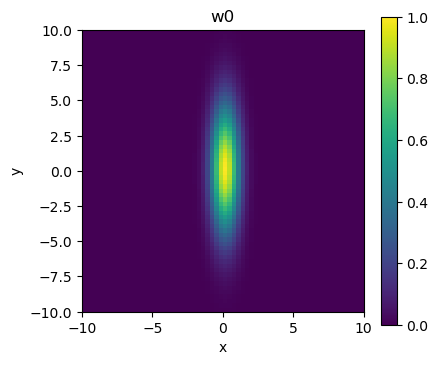

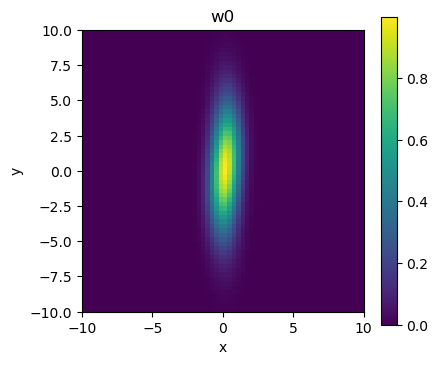

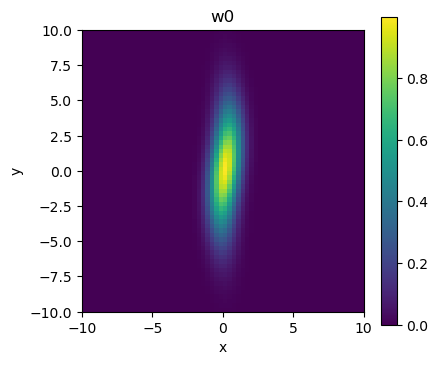

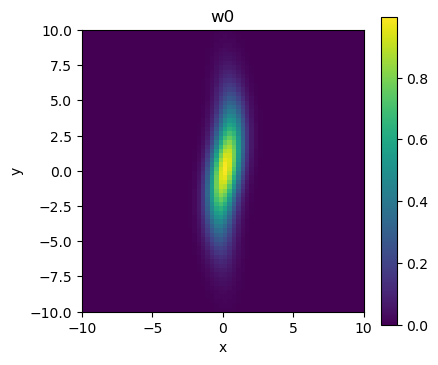

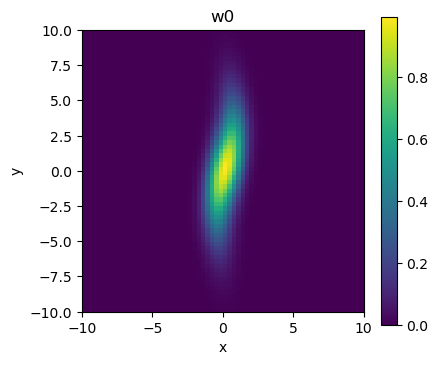

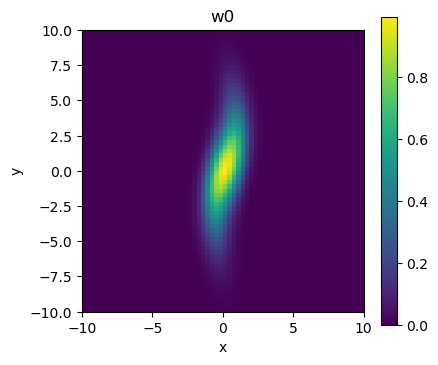

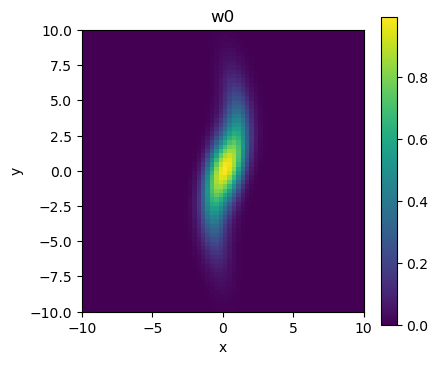

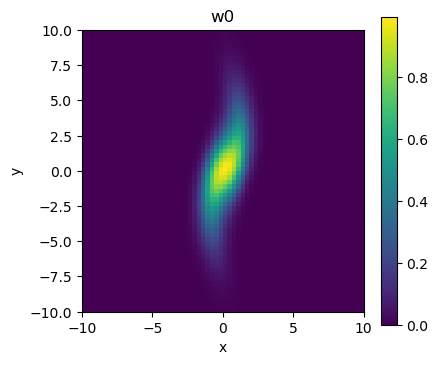

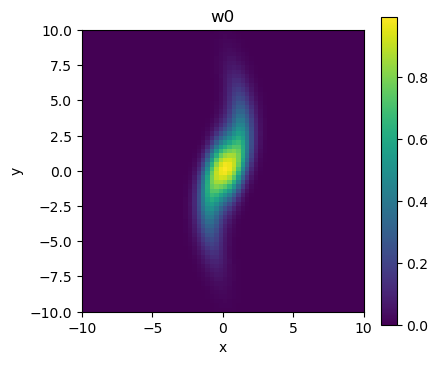

In [4]:
for j in range (9):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(A1[:,j].reshape(n,n), extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('w0')
    plt.xlabel('x')
    plt.ylabel('y')

In [57]:
### A / b

n = 64
l = 4
dl = 0.5
v = 0.001
tspan = np.linspace(0,l, 8 + 1)

X = np.linspace(-10,10,n+1)
Y = np.linspace(-10,10,n+1)

x = X[:n]
y = Y[:n]

x1, y1 = np.meshgrid(x, y)

w = np.exp((-x1**2) -((y1**2)/20))
deltaS = (20/n) **2

### A/ B


def a_b(w, tspan, n):
    
    matA[0,0] = 2/deltaS
    

    nx, ny = n, n
    N = nx * ny
    wVec = w.reshape(n**2,)
    
    def a_b_rhs(t, w, nx, ny, matA, matB, matC):
        psi_ab = spsolve(matA, w)
        
        return ((v * matA.dot(w)) - (matB.dot(psi_ab)) * (matC.dot(w)) + (matC.dot(psi_ab)) * (matB.dot(w)))
            
   
    sol_ab = solve_ivp(a_b_rhs, (tspan[0],tspan[-1]), wVec, method='RK45', t_eval=tspan, args = (nx, ny, matA, matB, matC))
    return sol_ab.y
       

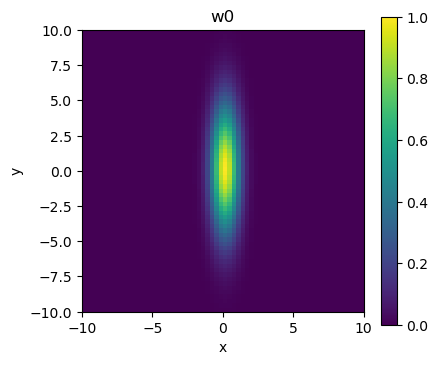

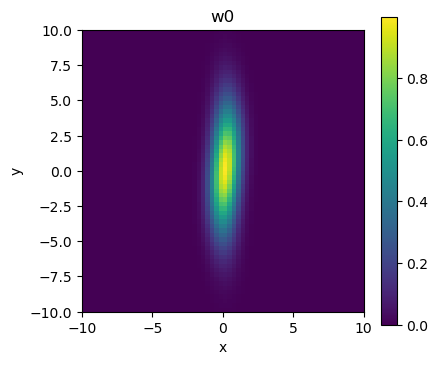

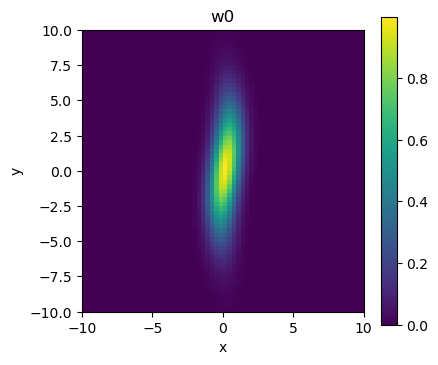

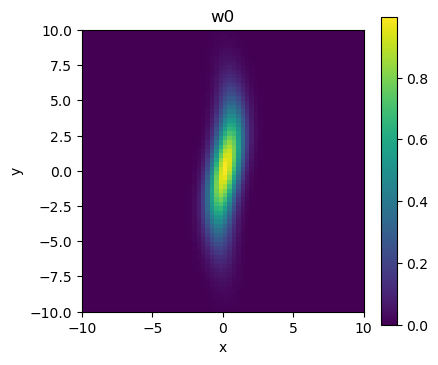

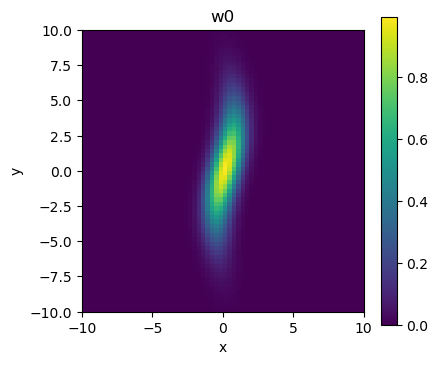

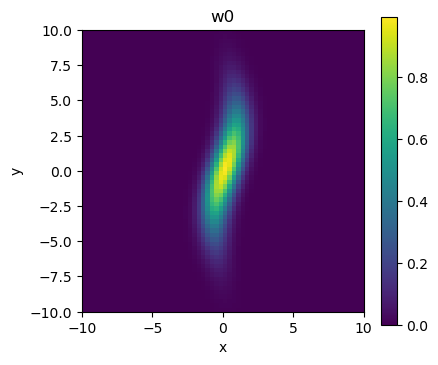

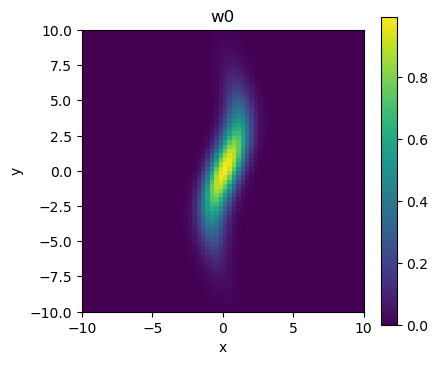

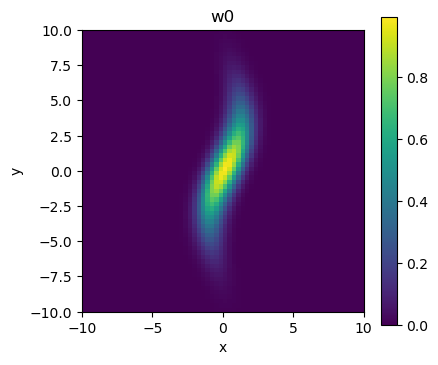

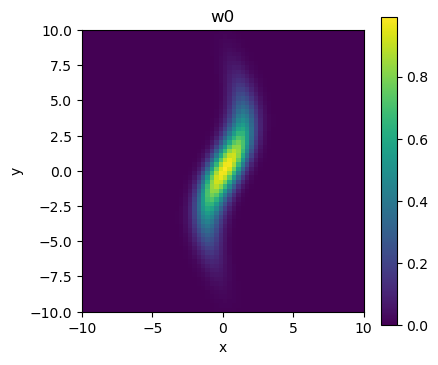

In [59]:
A2 = a_b(w, tspan, n)
# print(A2.shape)
for j in range (9):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(A2[:,j].reshape(n,n), extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('w0')
    plt.xlabel('x')
    plt.ylabel('y')

In [23]:

### lu decomp

n = 64
l = 4
dl = 0.5
v = 0.001
tspan = np.linspace(0,l, 8 + 1)
X = np.linspace(-10,10,n+1)
Y = np.linspace(-10,10,n+1)

x = X[:n]
y = Y[:n]

x1, y1 = np.meshgrid(x, y)

w0_lu = np.exp((-x1**2) -((y1**2)/20))

A[0,0] = 2/deltaS

P, L, U = lu(A)
deltax = 20/n
deltaS = (20/n) **2

def L_U(w0_lu, tspan, n):
    
    matA[0,0] = 2/deltaS
    
    wVec_lu = w0_lu.reshape(n**2,)
    # print("wVec_lu", wVec_lu)
    
    def lu_rhs(t, w, P, L, U, matA, matB, matC):
        
        Pb = np.dot(P, w)
        SOL = solve_triangular(L, Pb, lower=True)
        psi_lu = solve_triangular(U, SOL)
        
        return ((v * matA.dot(w)) - (matB.dot(psi_lu)) * (matC.dot(w)) + (matC.dot(psi_lu)) * (matB.dot(w)))
    
    sol = solve_ivp(lu_rhs, (tspan[0],tspan[-1]), wVec_lu, method='RK45', t_eval=tspan, args = (P, L, U, matA, matB, matC))
    # print("sol.y", sol.y.)
   
    
    return sol.y

wVec_lu [2.50656748e-46 1.17762859e-43 4.55107657e-41 ... 1.96785570e-38
 6.19028421e-41 1.60178709e-43]
(4096, 9)


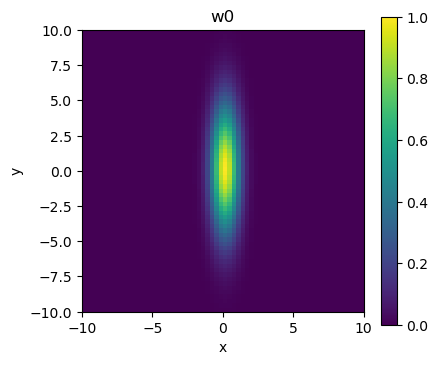

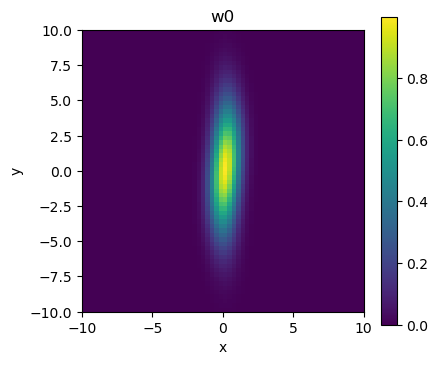

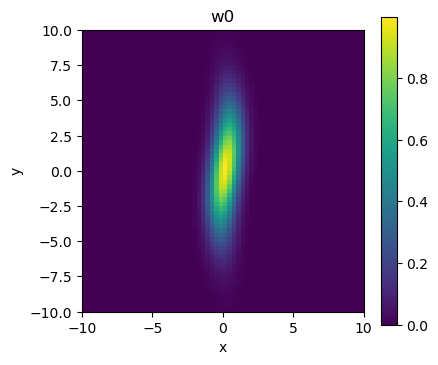

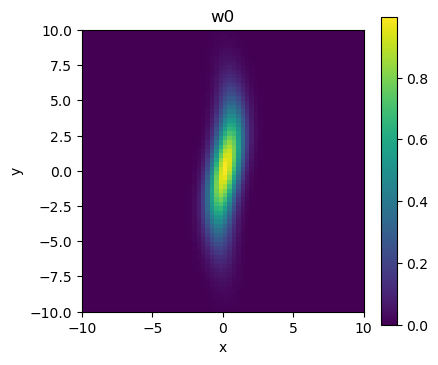

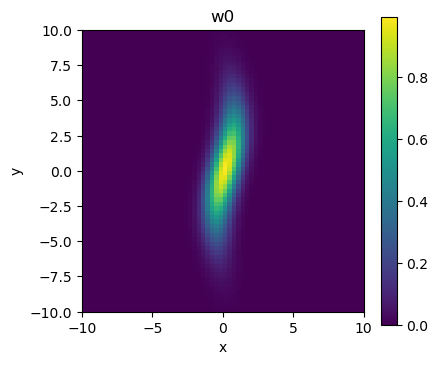

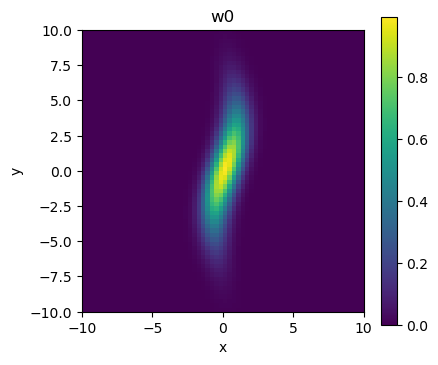

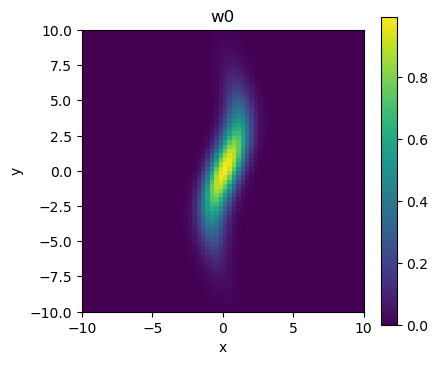

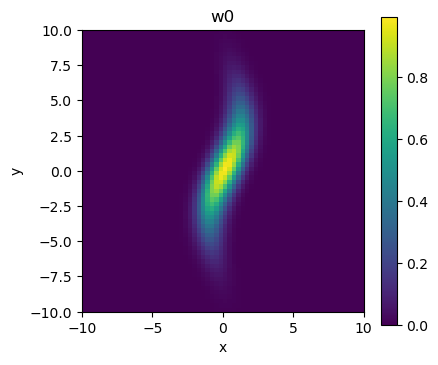

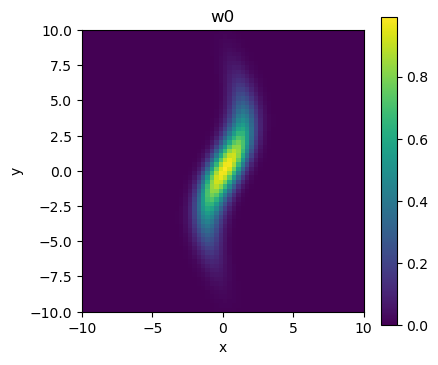

In [25]:
A3 = L_U(w0_lu, tspan, n)
# print(A3.shape)

for j in range (9):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(A3[:,j].reshape(n,n), extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('w0')
    plt.xlabel('x')
    plt.ylabel('y')

In [79]:
print("A1", A1)
print("A2", A2)
print("A3", A3)

A1 [[2.50656748e-46+0.j 3.59341830e-45+0.j 1.89210329e-44+0.j ...
  1.90724367e-42+0.j 4.82289181e-42+0.j 1.14837424e-41+0.j]
 [1.17762859e-43+0.j 6.53137927e-43+0.j 2.62162819e-42+0.j ...
  1.58776488e-40+0.j 3.56194205e-40+0.j 7.46787535e-40+0.j]
 [4.55107657e-41+0.j 1.92913165e-40+0.j 6.43048342e-40+0.j ...
  2.49221806e-38+0.j 5.07944167e-38+0.j 9.69635073e-38+0.j]
 ...
 [1.96785570e-38+0.j 1.23428810e-37+0.j 5.47735695e-37+0.j ...
  4.36494944e-35+0.j 1.02595060e-34+0.j 2.23502101e-34+0.j]
 [6.19028421e-41+0.j 5.33920485e-40+0.j 2.93799737e-39+0.j ...
  3.69276594e-37+0.j 9.48345882e-37+0.j 2.24375989e-36+0.j]
 [1.60178709e-43+0.j 1.99600098e-42+0.j 1.41321499e-41+0.j ...
  2.81144702e-39+0.j 7.98442619e-39+0.j 2.08296481e-38+0.j]]
A2 [[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ... -5.75086257e-26
  -6.68013806e-25  3.02201851e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.487